# Chapter 2 - Overview of Supervised Learning

## Preliminaries

**Quantitative** -  output $\in \mathbb{R}$. e.g. [1.2, 3.5, 7.6]

**Qualitative** - output $\in \mathbb{G}$ where $\mathbb{G}$ is some finite set. e.g. $\mathbb{G} = \{Lily, Daisy, Rose\}$

**Categorical** - qualitative variable. Also known as **discrete** or **factors**.

**Regression** - prediction task to predict quantitative outputs.

**Classification** - prediction task to predict qualitative outputs.

**Ordered categorical** - for example $\mathbb{G} = \{Small, Medium, Large\}$. The values have some sense of *order* but there is no measurable difference between them. e.g. We don't know the relative difference in size. Is small half the size of medium?

Qualitative variables will often be encoded as numbers because most algorithms require numerical values.  They will have to be treated carefully though in order to make mathematical sense.

Features are usually denoted as $X$.  Quantitative outputs as $Y$, and qualitative outputs as $G$.

## Linear Model

Makes huge assumptions about model structure, namely that it is linear.

Each input row can have 1 or more outcomes.  When we have more than 1 outcome to predict, we are actually predicting a linear hyperplane.

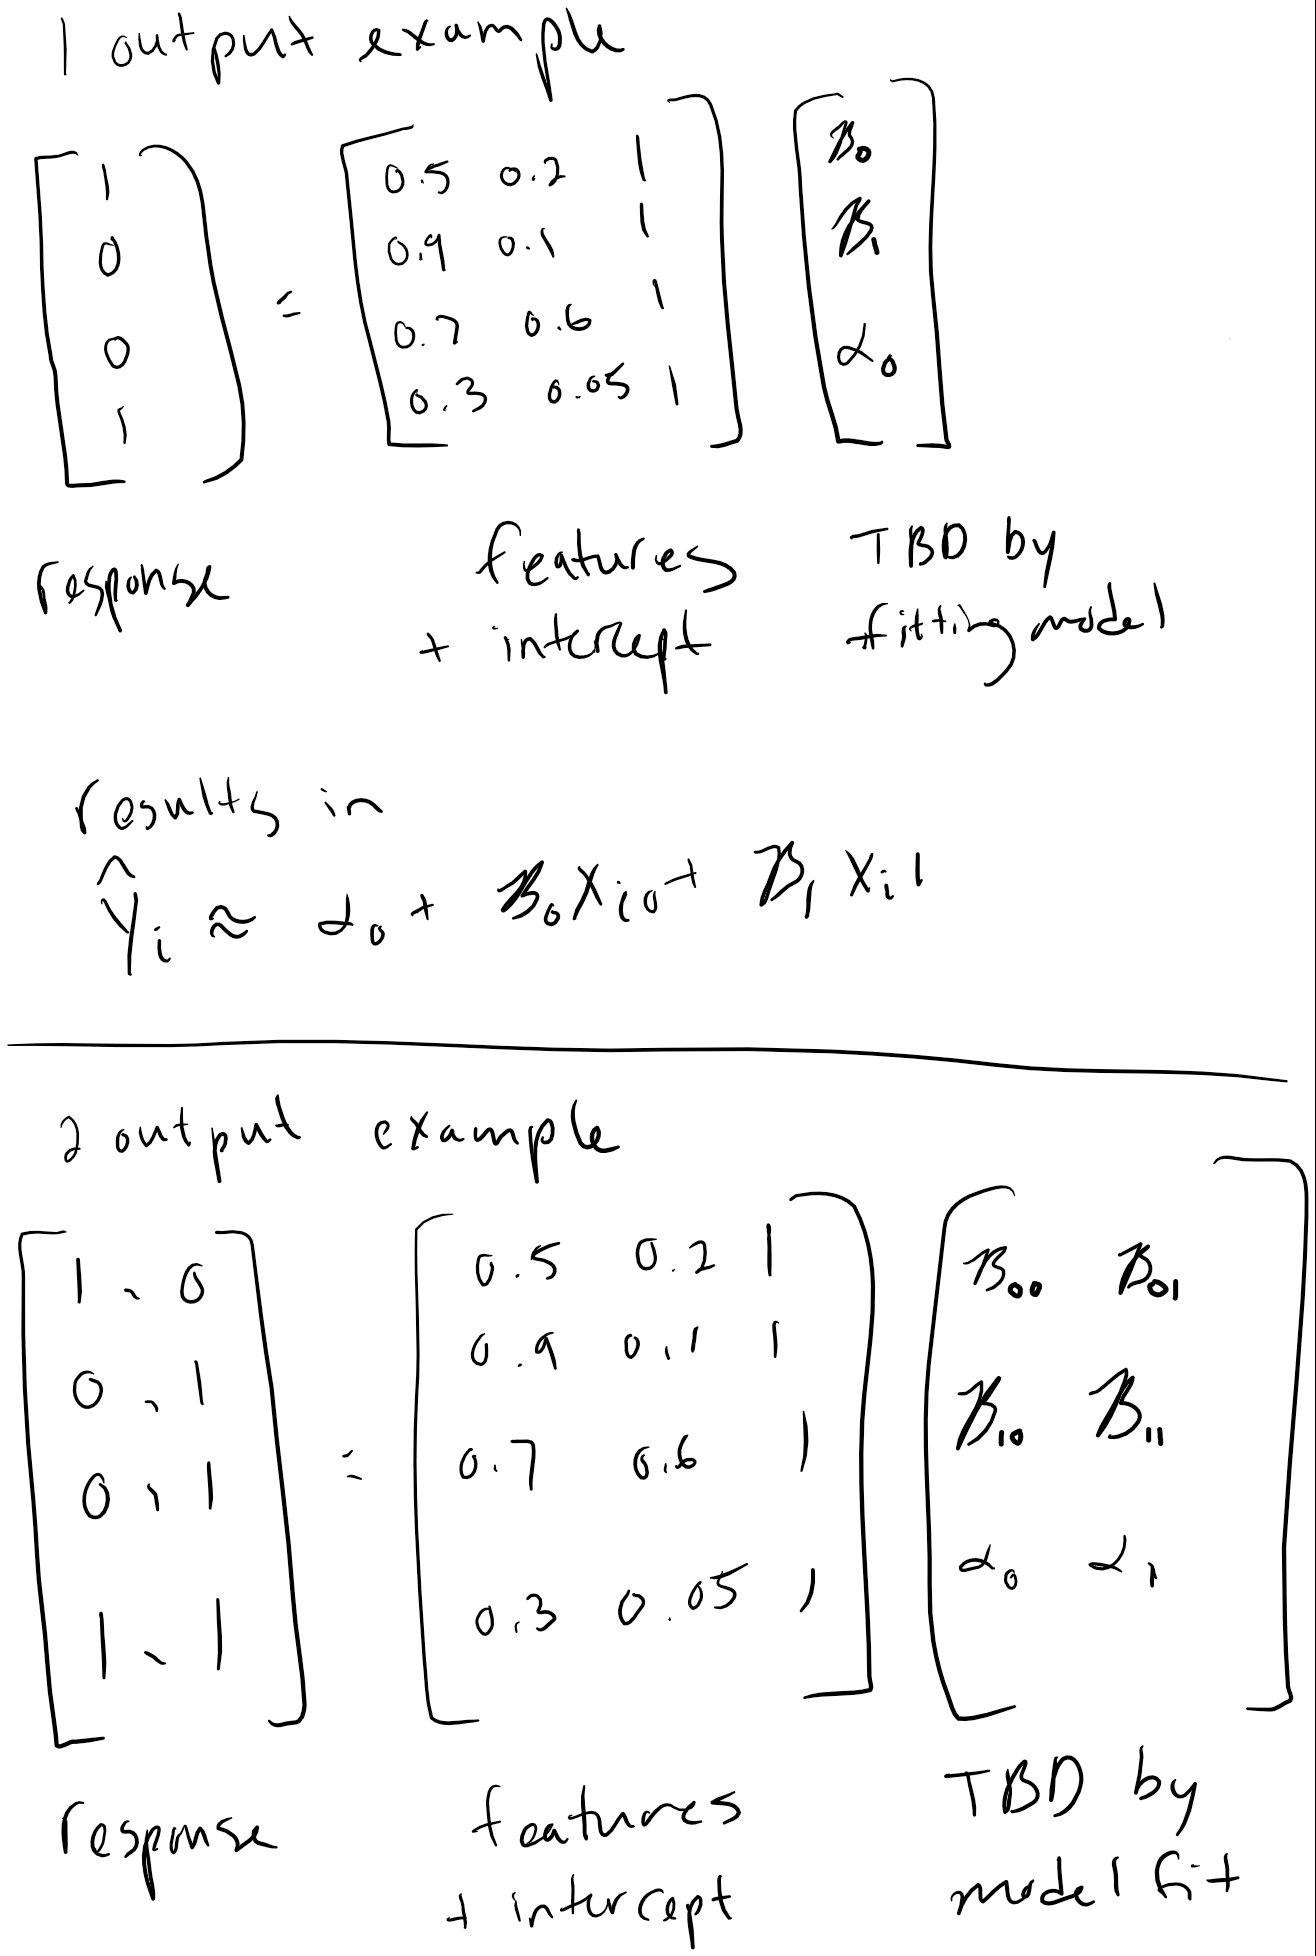

In [1]:
from IPython.display import Image
Image("./support/Chapter2/LinearModelExample.png", width=600, height=300)

## Land Temperature Example (1 output)

In this example we will fit a linear regression of 1 output to average land temperature over the last several centuries. For this simple example, we will not be using cross validation.

In [2]:
# Import libraries
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Load data
data = pandas.read_csv('./data/Chapter2/GlobalTemperatures.csv', delimiter=',')

In [4]:
# Describe the quantitative data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
LandAverageTemperature,3180.0,8.374731,4.381310,-2.080,4.31200,8.6105,12.54825,19.021
LandAverageTemperatureUncertainty,3180.0,0.938468,1.096440,0.034,0.18675,0.3920,1.41925,7.880
LandMaxTemperature,1992.0,14.350601,4.309579,5.900,10.21200,14.7600,18.45150,21.320
LandMaxTemperatureUncertainty,1992.0,0.479782,0.583203,0.044,0.14200,0.2520,0.53900,4.373
LandMinTemperature,1992.0,2.743595,4.155835,-5.407,-1.33450,2.9495,6.77875,9.715
LandMinTemperatureUncertainty,1992.0,0.431849,0.445838,0.045,0.15500,0.2790,0.45825,3.498
LandAndOceanAverageTemperature,1992.0,15.212566,1.274093,12.475,14.04700,15.2510,16.39625,17.611
LandAndOceanAverageTemperatureUncertainty,1992.0,0.128532,0.073587,0.042,0.06300,0.1220,0.15100,0.457


In [5]:
# Describe the qualitative data
data.describe(include=['O']).T

,count,unique,top,freq
dt,3192,3192,1910-01-01,1


In [6]:
# Compute null percentages for each column
data.isnull().sum()/data.count()

dt                                           0.000000
LandAverageTemperature                       0.003774
LandAverageTemperatureUncertainty            0.003774
LandMaxTemperature                           0.602410
LandMaxTemperatureUncertainty                0.602410
LandMinTemperature                           0.602410
LandMinTemperatureUncertainty                0.602410
LandAndOceanAverageTemperature               0.602410
LandAndOceanAverageTemperatureUncertainty    0.602410
dtype: float64

In [7]:
# Transform to average by year
data['year'] = data.apply(lambda x: datetime.strptime(x['dt'], '%Y-%m-%d').year, axis=1)
numeric_columns = data.columns[data.dtypes != 'object']
average_data = data[numeric_columns].groupby('year').mean().reset_index()

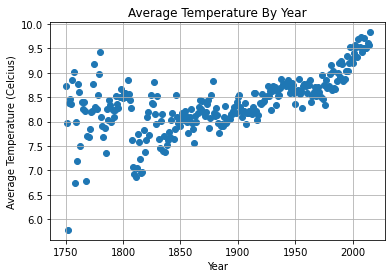

In [8]:
# Plot average temperature by year
plt.scatter(average_data['year'].values, average_data['LandAverageTemperature'].values)
plt.title('Average Temperature By Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (Celcius)')
plt.grid(True)

In [9]:
# Now let's fit a simple linear regression to the above with only "year" as a feature
X = average_data['year'].values
y = average_data['LandAverageTemperature'].values

In [10]:
from sklearn.linear_model import LinearRegression

The linear model will "fit" by minimizing the least-squares objective function.

In [11]:
lr = LinearRegression(fit_intercept=True, normalize=True, copy_X=True, n_jobs=1)

# Must reshape to 2D array since we only have 1 variable
X_reshaped = X.reshape(len(X), 1)
lr.fit(X_reshaped, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [12]:
print('Intercept: {0}'.format(lr.intercept_))
print('Slope: {0}'.format(lr.coef_[0]))

Intercept: -0.5380731373958252
Slope: 0.004731692034283842


In [13]:
# Fit regression back to data
predicted_1_var = lr.predict(X_reshaped)

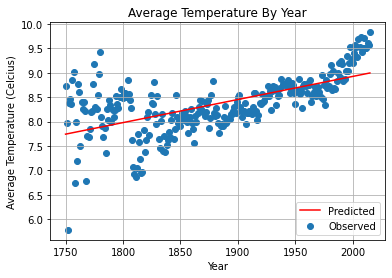

In [14]:
# Now plot again with the fitted line
plt.scatter(average_data['year'].values, average_data['LandAverageTemperature'].values)
plt.title('Average Temperature By Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (Celcius)')
plt.grid(True)

plt.plot(average_data['year'].values, predicted_1_var, color='red')
plt.legend(['Predicted', 'Observed'])

In [15]:
# R^2 score
lr.score(X_reshaped, y)

0.3873026972956111

In [16]:
# Now let's use all variables.  Since we cannot use "null" in a mathematical optimization algorithm (e.g. gradient descent)
# we must impute values. Let's do a simple columnwise mean imputation
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')

feature_columns = [col for col in average_data.columns if col != 'LandAverageTemperature']
X = average_data[feature_columns].values
y = average_data['LandAverageTemperature'].values
X_imputed = imp.fit_transform(X)

In [17]:
# Now lets fit our model
lr.fit(X_imputed, y)
predicted_all_vars = lr.predict(X_imputed)

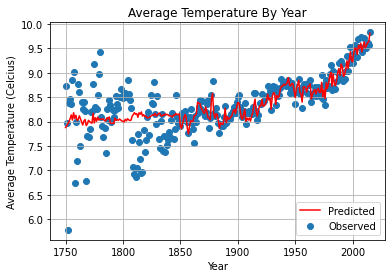

In [18]:
# Now plot again with the fitted line
plt.scatter(average_data['year'].values, average_data['LandAverageTemperature'].values)
plt.title('Average Temperature By Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (Celcius)')
plt.grid(True)

plt.plot(average_data['year'].values, predicted_all_vars, color='red')
plt.legend(['Predicted', 'Observed'])

In [19]:
# R^2 score
lr.score(X_imputed, y)

0.5607095072957367

In this example, the R^2 metric improved as we added more variables.

In [20]:
print('Intercept: {0}'.format(lr.intercept_))
for i in range(len(lr.coef_)):
    print('{0} : {1}'.format(feature_columns[i], lr.coef_[i]))

Intercept: -17.520206069903637
year : 0.006096550394447334
LandAverageTemperatureUncertainty : 0.18740840151913396
LandMaxTemperature : 0.34498291177777546
LandMaxTemperatureUncertainty : -0.09937774606433306
LandMinTemperature : -0.000249249114775602
LandMinTemperatureUncertainty : 0.005611428290247141
LandAndOceanAverageTemperature : 0.5929319973550414
LandAndOceanAverageTemperatureUncertainty : 2.4177810947402962


## K-Nearest Neighbors

Prediction is the average of the k-nearest neighbors for a record, where nearness is defined as Euclidean distance on the feature space $X$.

$||\vec{p}|| = \sqrt{p_{1}^{2} + p_{2}^{2} + p_{3}^{2} \dots + p_{n}^{2}}$  also known as the $L_2$  or Euclidean norm of a vector.

For 2 vectors $\vec{p}$ and $\vec{q}$:

$||\vec{p} - \vec{q}|| = \sqrt{||\vec{p}||^2 + ||\vec{q}||^2 - 2\vec{p}\vec{q}}$

In [21]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)

In [22]:
# Now lets fit our model. Use imputation from above
knn.fit(X_imputed, y)
predicted_knn = knn.predict(X_imputed)

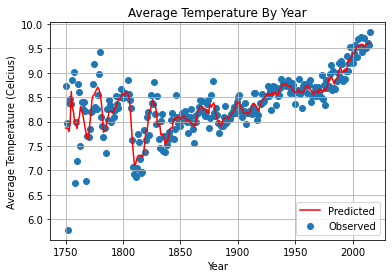

In [23]:
# Now plot again with the fitted line
plt.scatter(average_data['year'].values, average_data['LandAverageTemperature'].values)
plt.title('Average Temperature By Year')
plt.xlabel('Year')
plt.ylabel('Average Temperature (Celcius)')
plt.grid(True)

plt.plot(average_data['year'].values, predicted_knn, color='red')
plt.legend(['Predicted', 'Observed'])

In [24]:
# R^2 score
knn.score(X_imputed, y)

0.7664797762464489

5 nearest neighbors gives us a higher R^2 score than simple linear regression.

But since we did not do cross-validation, this result cannot be trusted to generalize to new data.

Error is an increasing function with respect to K, and will always be 0 for k=1 (on the training data).  But if we pick k=1, the learner might not *generalize* well outside of the training set.

Kernel methods can be used which create a weighted average of neighbors based on distance from point.

## 2.4 notes


Linear models fit to a basis expansion can create abitrary complexity (e.g. create non-linear terms).

**Loss function** - function that quantifies and penalizes the error in prediction.  Typically a learner will seek to minimize this when fitting.

The best prediction of Y at any point X=x is the conditional mean, when the "best" is measured by averaged squared error.

As dimensionality increases, so does the metric size of the k-nearest neighborhood, making it less accurate (things are further than they seem). Convergence to conditional mean holds, but the rate of convergence decreases as dimension increases.

Least squares assumes f(x) is well approximated by a globally linear function, while k nearest neighbors assumes f(x) is well approximated by a locally constant function.

Additive models (we will discuss in later chapters) can work better in high dimensions but at the assumption of additivity.

If L2 loss function (e.g. MSE) is replaced by L1 (e.g. MAE), then the optimal solution is the conditional median, which is more robust and stable. However, discontinuities in derivatives hinder their widespread use (makes it hard to train an optimizer like gradient descent).

Qualitative targets require a diff. loss function, such as the zero-one loss function (penalize misclassifications). The outcome is known as the Bayes classifier and says that we classify to the most probable class according to the conditional distribution P(G|X).


## 2.5 notes

**Curse of dimensionality** - the various phenomena that make it difficult to model in high dimensions. With a uniformly distributed hypercube of data points in 10 dimensions, you must cover 80% of the range of each coordinate to capture 10% of the data. This makes the averages no longer "local".

Sampling also becomes difficult. In high dimensionals all feasible training samples sparsely populate the input space (feasible = reasonable size for computation).

**Bias variance tradeoff** - Decomposition always possible. These measures are always inversely propotional.


## 2.6 notes

Up to this point we have made assumptions that error is additive and independent of X. Modifications can be made (and will in later chapters) to relax these assumptions. Additive error models are not typically used for qualitative outputs.

High level view of machine learning - we feed inputs into an artificial system known as a learning algorithm (usually a computer program) which produces outputs f(x) in response to the inputs. The algorithm can then modify the function $\hat{f}(x)$ in response to the differences $y_i - \hat{f}(x_i)$ in hopes that the artificial and real outputs are close enough to be usefull for all likely sets of inputs encountered in practice.

We usually assume inputs are in the Euclidean space, although in general they can be in the affine space (maintain parallelism and angles but not measurability).

The book touches on possible polynomial or trigonometric basis expansions on the input X.

MLE methods -- we may cover this later.

## 2.7 notes

RSS = residual sum of squares

Given finite set of discrete training points, there are infinitely many estimators that can minimize RSS. The particular chosen solution might be a poor predictor at test points different than training points (since our training set isn't a dense representation of the universal space).

To account for this, most methods use some type of complexity restriction that enforce regular behavior in small neighborhoods of the input space. i.e. If inputs are close together, there is a nearly constant, linear, or low-order polynomial behavior in that neighborhood.

## 2.8 notes

Smoothing functions penalize roughness in a local neighborhood (e.g. large values of second derivative).

Kernel functions can explicitly specificy the nature of a local neighborhood, usually by assigning weights to points in a region around $x_0$.

Basis expansion methods - creates smoothing by averaging different local structures.

Dictionary methods - adaptive basis expansions where the set of basis functions is adaptively chosen with some kind of search mechanism.

## 2.9 notes

As model complexity of the procedure is increased, the variance tends to increase and the squared bias tends to decrease. The opposite happens as complexity decreases.

However, we need to choose the correct bias/variance tradeoff to minimize the *test* error. That is, the error when the learner has to predict to a more general space.

If the model adapts too closely to the training data, we are *overfit*.  Otherwise, if it does not adapt enough, then we are *underfit*.  The correct level of fitness is usually determined by how well the model will generalize to a larger set of inputs.  We will discuss this later when we talk about cross-validation.

